# Importing/Storing data

In [1]:
# pip install wfdb
# pip install xgboost 
#print('Current directory is: {}'.format(os.getcwd()))

In [2]:
%run "MIT-BIH Normal Sinus Rhythm DB.ipynb"

int32
float64
1806791
-11
Divisble by 20 --> 1806780
Features for that specific segment:
Mean                156.300
STD                  13.104
RMSSD                 0.183
Normalized RMSSD      0.001
dtype: float64

features_nsr variable contains 90339 segments
float64
Length of y_list: 90339
shape of y: (18067,), type of y: <class 'numpy.ndarray'>
shape of X_test_nsr: (18067, 4), type of X_test_nsr: <class 'numpy.ndarray'>


In [3]:
import wfdb
import os
import glob
import pandas as pd
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
# import matlab.engine
# eng = matlab.engine.start_matlab()
# eng.ecgpuwave(-r 'C:/Users/masud/Desktop/Github_Bachelor_Project/wfdb-python/data/')

In [5]:
records = []
properties = []
annot = []
AnnSymb = []
AnnSamp = []
AnnRhythm = []
Rpeak_Samp = []
Rpeak_Symb = []


for f in glob.glob('C:/Users/masud/Desktop/Github_Bachelor_Project/wfdb-python/data/*.dat'): ##### change the path (afib) to your own directory. The rest should 
                                                                                             ##### remin the same
    sig, fields = wfdb.rdsamp(f[:-4], channels=[1])  #### In this function, you have the opportunity to pass 
                                       #### "channels=[0]" or "channels=[1]" to select channel 1 or 2.
    ann = wfdb.rdann(f[:-4], 'atr')
    QRS = wfdb.rdann(f[:-4], 'qrs')
    Symb = pd.Series(ann.symbol)
    Samp = pd.Series(ann.sample)
    QRS_Symb = pd.Series(QRS.symbol)
    QRS_Samp = pd.Series(QRS.sample)
    Rhythm = pd.Series(ann.aux_note)
    records.append(sig)
    properties.append(fields)
    annot.append(ann)
    AnnSymb.append(Symb)
    AnnSamp.append(Samp)
    Rpeak_Symb.append(QRS_Symb)
    Rpeak_Samp.append(QRS_Samp)
    AnnRhythm.append(Rhythm)
    
    

AnnSymb = pd.Series(AnnSymb).values
AnnSamp = pd.Series(AnnSamp).values

# P-Wave detection

In [6]:
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
dir = 'C:/Users/masud/Desktop/Github_Bachelor_Project/wfdb-python/data/'

In [7]:
#Create folder
dir_out = dir + 'atr_text/'
if not exists(dir_out):
    mkdir(dir_out)

### rdann -r record -f 0 -a atr -v > output_dir/name_record_atr.txt

command_WDFB_to_text_atr = rdann -r record -f 0 -a atr -v > output_dir/name_record_atr.txt
print(command_WDFB_to_text_atr)
system(command_WDFB_to_text_atr)

SyntaxError: invalid syntax (<ipython-input-7-7b3613d95b15>, line 8)

In [ ]:
#Create folder
dir_out = dir + 'atr_qrs/'
if not exists(dir_out):
    mkdir(dir_out)

### rdann -r record -f 0 -a qrs -v > output_dir/name_record_qrs.txt
command_WDFB_to_text_qrs = 'rdann -r ' + dir + '04908 -f 0 -a qrs -v > ' + dir + 'atr_qrs/04908_qrs.txt'
print(command_WDFB_to_text_qrs)
system(command_WDFB_to_text_qrs)

### ecgpuwave_mitdb.py

In [ ]:
# this script detect P, QRS, T onset/offset waves from MITDB data and save 
# in text files

from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists


dir = 'C:/Users/masud/Desktop/Github_Bachelor_Project/wfdb-python/data/'

#Create folder
dir_out = dir + 'qrs/'
if not exists(dir_out):
    mkdir(dir_out)

records = [f for f in listdir(dir) if isfile(join(dir, f)) if(f.find('.dat') != -1)]
#print records

for r in records:
    command = 'ecgpuwave -r ' + dir +r[:-4] + ' -a qrs'
    print(command)
    system(command)

    command_annotations = 'rdann -r ' + dir +r[:-4] +' -f 0 -a qrs -v >' + dir_out + r[:-4] + 'qrs.txt'
    print(command_annotations)
    system(command_annotations)

In [ ]:
# records_nsr[0].flatten()
# np.shape(records_nsr[0])
reshaped_rec = np.reshape(records[0],9205760)
print(np.shape(reshaped_rec))
print(type(records[0]))

In [ ]:
#find_peaks = processing.find_peaks(reshaped_rec)

In [ ]:
#find_peaks.

# Pre processing data...

In [8]:
# print(AnnRhythm[0])
# print("------------------------------------")
# print(AnnSamp[0])
# print("------------------------------------")
# print("All samples of R-peaks below")
# print(Rpeak_Samp[0])
# print("------------------------------------")
# print(Rpeak_Symb[0])
# print(records[0])
# print(type(records[0]))
# print(np.where(Rpeak_Samp[22] <= ))
# df.iloc[22] # acessing ROW 22
# print("------------------------------------")

In [9]:
x = 0
for i in range(23):
    x += np.sum(len(Rpeak_Samp[i]))
print(f"All Rpeaks amount: {x}")

All Rpeaks amount: 1128561


In [10]:
labeled_Rpeaks = []
appended_data = []
for i in range(23): ## 23 records
    for j in range(len(AnnSamp[i])-1): ## AnnSamp or AnnRhythm -- both same dimensions
        df = pd.DataFrame(Rpeak_Samp[i][(Rpeak_Samp[i] > AnnSamp[i][j]) & (Rpeak_Samp[i] < AnnSamp[i][j+1])])
        df['Label'] = AnnRhythm[i][j]
        appended_data.append(df)
        

labeled_Rpeaks = pd.concat(appended_data)

### Filter, only get Hearbeats with annotations '(N' OR '(AFIB'

In [11]:
labeled_Rpeaks_N_AFIB = labeled_Rpeaks.loc[(labeled_Rpeaks.Label == '(N') | (labeled_Rpeaks.Label == '(AFIB'), :]
labeled_Rpeaks_N_AFIB[:]

,0,Label
0,61,(N
1,200,(N
2,358,(N
3,584,(N
4,729,(N
...,...,...
15373,2849597,(N
15374,2849785,(N
15375,2849975,(N
15376,2850083,(N


### Convert 'Label' column to boolean expr

In [12]:
### s.where(s > 1, 10)
#labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype('bool')
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].map( 
                   {'(N':False ,'(AFIB':True}) 

<ipython-input-12-36743a647d57>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].map(


In [13]:
labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype(int)

labeled_Rpeaks_N_AFIB.rename(columns={0: 'Rpeaks'},
          inplace=True, errors='raise')

<ipython-input-13-9cd7ad84a37a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_Rpeaks_N_AFIB['Label'] = labeled_Rpeaks_N_AFIB['Label'].astype(int)
D:\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [14]:
Rpeaks_N_AFIB = labeled_Rpeaks_N_AFIB["Rpeaks"]
Label_N_AFIB = labeled_Rpeaks_N_AFIB["Label"]
Label_N_AFIB = np.array(Label_N_AFIB, dtype=np.float64)

#labeled_Rpeaks_N_AFIB[0:1000]
labeled_Rpeaks_N_AFIB.isnull().values.any() ### Check for NaN values

False

### Window slider

In [15]:
#print(records[0])
#print(np.shape(records[0]))
#print()
#print()
#records_trans = np.transpose(records[0])
#print(np.shape(records_trans))
#records[0].flatten()
#np.squeeze(records[0], axis=1)
#np.shape(records[0])

In [16]:
###Run with heartbeats ##convert to numpy array 
#from window_slider import Slider
#import numpy
#list = records_trans
#bucket_size = 6600
#overlap_count = 3300
#slider = Slider(bucket_size,overlap_count)
#slider.fit(list)       
#while True:
#    window_data = slider.slide()
#    # do your stuff
#    print(window_data)
#    if slider.reached_end_of_list(): break

### Visualising the ECG signals

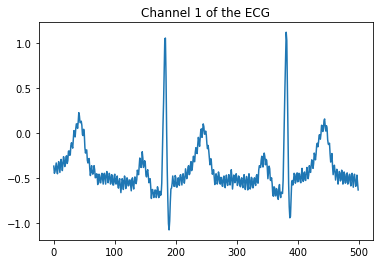

In [17]:
#plt.title("Both Channels (0 and 1)")
#plt.title("Channel 0 of the ECG") #Called ['ECG1']
plt.title('Channel 1 of the ECG') #Called ['ECG2']
plt.plot(sig[:500])

#################### Accessing annotations 
#display(fields) ### Last record annotation
#print(f"Units in which the ECG is measured {fields['units']}")
#display(properties[22])
#print(f"Units in which the ECG is measured {properties[22]['units']}")

# Segmenting & Calculating features

### X

In [18]:
def segmenting_record(seg_value):
    rri2 = np.diff(Rpeaks_N_AFIB) ### Storing the intervals between rpeaks
    #print(rri2.dtype)
    rri2 = np.array(rri2, dtype=np.float64) ### So no overflow issues happens when calc in for loop later
    #print(rri2.dtype)
    #print(f"length before: {len(rri2)}")
    amount = -(len(rri2) % seg_value) #
    print(f"Amount to remove {amount}")
    rec_amount = rri2[:amount]
    #print(f"length before: {len(rec_amount)}")
    seg_shape = len(rec_amount) // seg_value #
    print(f"Shape 0: {seg_shape}")
    segmented_rec = rec_amount.reshape(seg_shape,seg_value) #
    return segmented_rec

In [78]:
segmented_record = segmenting_record(20)

Amount to remove -6
Shape 0: 35428


In [79]:
features2 = []

    ### Calculating features for every single segmented "block" inside the segmented_record variable
for x in range(len(segmented_record)):
    #MEAN
    ff1 = np.nanmean(segmented_record[x]) ### nanmean, nanstd computes values while ignoring nan-values
    #STD
    ff2 = np.nanstd(segmented_record[x])
    #RMSSD
    sum_ = 0
    for y in range(len(segmented_record[x]) - 1): ### loops 19 times
        sum_ += (segmented_record[x][y] - segmented_record[x][y+1])**2
    sum_multiplied = 1/(len(segmented_record) - 1) * sum_
    ff3 = np.sqrt(sum_multiplied)
    #NORMALIZED RMSSD
    ff4 = (ff3 / ff1)
    ### COVARIANCE
    #z = np.stack((ff1, ff2))
    #ff5 = np.cov(z) ### try cov with previous segment

    my_features2 = pd.Series([np.around(ff1,3), np.around(ff2,3), np.around(ff3,3), np.around(ff4,3)], 
                            index=['Mean','STD','RMSSD','Normalized RMSSD'])
    features2.append(my_features2)

In [80]:
n = 0

print(f"Features for that specific segment:\n{features2[n]}") 
print('\n'f"features2 variable contains {len(features2)} segments")

Features for that specific segment:
Mean                168.250
STD                  43.226
RMSSD                 1.115
Normalized RMSSD      0.007
dtype: float64

features2 variable contains 35428 segments


### Y

In [81]:
y_amount = Label_N_AFIB[:-7] ### So it is divisible by 20 ######
y_shape = y_amount.reshape(35428, 20) ######
y_list = []

### Calc if every 20 segment block is Normal synus rythm or AFIB
for l in range(len(y_shape)):
    #y_segment = y_shape
    sum_segment = np.sum(y_shape[l])
    if sum_segment >= 10: ######
        sum_segment = 1
    else: sum_segment = 0
    y_list.append(sum_segment)

y_list = np.array(y_list, dtype=np.float64)
print(y_list.dtype)
print(f"Length of y_list: {len(y_list)}")

float64
Length of y_list: 35428


# Estimators -> Classifications algorithms

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [82]:
y = np.asarray(y_list)
print(f"shape of y: {np.shape(y)}, type of y: {type(y)}")
X = np.asarray(features2)
print(f"shape of X: {np.shape(X)}, type of X: {type(X)}")

shape of y: (35428,), type of y: <class 'numpy.ndarray'>
shape of X: (35428, 4), type of X: <class 'numpy.ndarray'>


In [25]:
df5 = pd.DataFrame(features2)
X = df5.values
df5

,Mean,STD,RMSSD,Normalized RMSSD
0,168.25,43.226,1.115,0.007
1,169.10,50.353,1.126,0.007
2,150.75,62.874,1.669,0.011
3,194.20,32.262,1.038,0.005
4,169.85,43.731,1.013,0.006
...,...,...,...,...
35423,189.30,2.326,0.052,0.000
35424,188.80,2.272,0.048,0.000
35425,188.00,2.000,0.056,0.000
35426,187.85,1.621,0.051,0.000


### SVM

In [26]:
model = SVC()

In [27]:
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# clf = GridSearchCV(model, parameters)
# clf.fit(X_train, y_train)

# df_svm_results = pd.DataFrame(clf.cv_results_)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# scaler = StandardScaler()
# scaler.fit(X)
# scaler.transform(X)

### Decision trees

In [28]:
# clf = tree.DecisionTreeClassifier()
# clf.fit(X_train, y_train)

In [29]:
#clf.score(X_test, y_test) 

### Random forest

In [30]:
# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)

In [31]:
# rf_y_predicted = clf.predict(X_test)
# cm = confusion_matrix(y_test, rf_y_predicted)
# %matplotlib inline
# plt.figure(figsize=(6,4))
# sn.heatmap(cm,annot=True)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')

# Pipelines

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [33]:
##### Choosen params after runned GridsearchCV 

pipeline_svm = Pipeline([('scalar1', StandardScaler()),
                         ('svm_classifier', SVC(gamma="scale", C=20, kernel='rbf', probability=True))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('dt_classifier', tree.DecisionTreeClassifier(criterion='entropy', max_depth=12))])

pipeline_nb = Pipeline([('scalar3', StandardScaler()),
                       ('nb_classifier', GaussianNB())]) ### No gridsearch, because no hyperparameters

pipeline_rf = Pipeline([('scalar 4', StandardScaler()),
                         ('rf_classifier', RandomForestClassifier(n_estimators=200))])


# Ensemble classifiers

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### StackingClassifier

In [35]:
estimators = [('svm',pipeline_svm), ('dt',pipeline_dt), ('nb',pipeline_nb), ('rf',pipeline_rf)]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())


### xgboost

In [36]:
xgb_model = XGBClassifier()

### AdaBoost

In [37]:
adaBoost_clf = AdaBoostClassifier()

# Cross validation

In [38]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold ### For class inbalances through out the data

In [83]:
scoring = ['precision_macro']

cv_swm_results = cross_validate(pipeline_svm, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False) ### set return_estimator=True to return the fitted estimator

In [84]:
%%time
cv_dt_results = cross_validate(pipeline_dt, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)
cv_nb_results = cross_validate(pipeline_nb, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)
cv_rf_results = cross_validate(pipeline_rf, X, y,
                        scoring=scoring, cv=5,
                        return_estimator=False)

Wall time: 36.5 s


In [85]:
# %%time ##takes half hour to run
# cv_stacking_results = cross_validate(clf, X, y,
#                         scoring=scoring, cv=5,
#                         return_estimator=False)
# cv_xgb_results = cross_validate(xgb_model, X, y,
#                         scoring=scoring, cv=5,
#                         return_estimator=False)
# cv_ab_results = cross_validate(adaBoost_clf, X, y,
#                         scoring=scoring, cv=5,
#                         return_estimator=False)

### Predict values

In [46]:
pipeline_svm.fit(X_train, y_train)
pipeline_dt.fit(X_train, y_train)
pipeline_nb.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

clf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
adaBoost_clf.fit(X_train, y_train)

Pipeline(steps=[('scalar 4', StandardScaler()),
                ('rf_classifier', RandomForestClassifier(n_estimators=200))])

In [42]:
# %%time
# y_swm_pred = cross_val_predict(pipeline_svm, X, y)
# y_dt_pred = cross_val_predict(pipeline_dt, X, y)
# y_nb_pred = cross_val_predict(pipeline_nb, X, y)
# y_rf_pred = cross_val_predict(pipeline_rf, X, y)

Wall time: 5min 39s


In [62]:
#r_probs = [0 for _ in range(len(y_test))]
probs_swm = pipeline_svm.predict_proba(X_test)
probs_dt = pipeline_dt.predict_proba(X_test)
probs_nb = pipeline_nb.predict_proba(X_test)
probs_rf = pipeline_rf.predict_proba(X_test)

probs_stacking = pipeline_rf.predict_proba(X_test)
probs_xgb = pipeline_rf.predict_proba(X_test)
probs_ab = pipeline_rf.predict_proba(X_test)

### Probabilities for the positive outcome is kept
probs_swm = probs_swm[:,1]
probs_dt = probs_dt[:,1]
probs_nb = probs_nb[:,1]
probs_rf = probs_rf[:,1]

probs_stacking = probs_stacking[:,1]
probs_xgb = probs_xgb[:,1]
probs_ab = probs_ab[:,1]

In [63]:
auc_svm = metrics.roc_auc_score(y_test, probs_swm)
auc_dt = metrics.roc_auc_score(y_test, probs_dt)
auc_nb = metrics.roc_auc_score(y_test, probs_nb)
auc_rf = metrics.roc_auc_score(y_test, probs_rf)

auc_stacking = metrics.roc_auc_score(y_test, probs_stacking)
auc_xgb = metrics.roc_auc_score(y_test, probs_xgb)
auc_ab = metrics.roc_auc_score(y_test, probs_ab)

In [64]:
fpr_swm, tpr_swm, thresholds_swm = metrics.roc_curve(y_test, probs_swm)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, probs_dt)
fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(y_test, probs_nb)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, probs_rf)

fpr_stacking, tpr_stacking, thresholds_stacking = metrics.roc_curve(y_test, probs_stacking)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(y_test, probs_xgb)
fpr_ab, tpr_ab, thresholds_ab = metrics.roc_curve(y_test, probs_ab)

# Results

In [50]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.datasets import make_classification

### scores

In [86]:
print(f"SWM Scores: {cv_swm_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_swm_results['test_precision_macro'])}")
print()
print(f"Decision tree Scores: {cv_dt_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_dt_results['test_precision_macro'])}")
print()
print(f"Naive bayes Scores: {cv_nb_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_nb_results['test_precision_macro'])}")
print()
print(f"Random forest: {cv_rf_results['test_precision_macro']}")
print(f"Mean: {np.mean(cv_rf_results['test_precision_macro'])}")
# print()
# print(f"Stacking classifier Scores: {cv_stacking_results['test_precision_macro']}")
# print(f"Mean: {np.mean(cv_stacking_results['test_precision_macro'])}")
# print()
# print(f"xgboost Scores: {cv_xgb_results['test_precision_macro']}")
# print(f"Mean: {np.mean(cv_xgb_results['test_precision_macro'])}")
# print()
# print(f"adaBoost Scores: {cv_ab_results['test_precision_macro']}")
# print(f"Mean: {np.mean(cv_ab_results['test_precision_macro'])}")

SWM Scores: [0.92118499 0.86178046 0.84719857 0.85588685 0.77298434]
Mean: 0.8518070430052868

Decision tree Scores: [0.90880095 0.89799804 0.87084112 0.88065041 0.78257661]
Mean: 0.8681734246277788

Naive bayes Scores: [0.51917108 0.55599557 0.40606327 0.50279532 0.57143782]
Mean: 0.5110926102570704

Random forest: [0.90906989 0.88906695 0.88661065 0.90550444 0.79950007]
Mean: 0.8779504029063112


### Evaluate on MIT-BIH Normal Sinus Rhythm Database

In [52]:
print(f"SVM: {pipeline_svm.score(X_test_nsr, y_test_nsr)}")
print(f"DT: {pipeline_dt.score(X_test_nsr, y_test_nsr)}")
print(f"NB: {pipeline_nb.score(X_test_nsr, y_test_nsr)}")
print(f"RF: {pipeline_rf.score(X_test_nsr, y_test_nsr)}")

SVM: 0.9377317761664914
DT: 0.923839043560082
NB: 0.9994465046770354
RF: 0.9443183705097692


### Clasification report for SVM

In [53]:
# y_pred_test = pipeline_svm.predict(X_test)
# # print(classification_report(y_pred_test, y_test))

# ### (above) the parameters was inputted in wrong positions.
# target_names = ['class 0', 'class 1']
# print(classification_report(y_test, y_pred_test, target_names=target_names))

### Confusion Matrix

In [54]:
y_pred_svm = pipeline_svm.predict(X_test)
y_pred_dt = pipeline_dt.predict(X_test)
y_pred_nb = pipeline_nb.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_nb = confusion_matrix(y_test, y_pred_nb)
cm_rf = confusion_matrix(y_test, y_pred_rf)
target_names = ['Normal', 'AFIB']

In [55]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

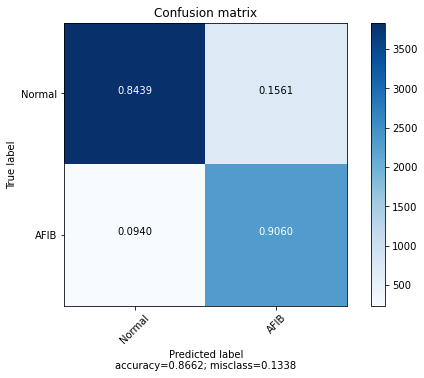

In [56]:
plot_confusion_matrix(cm=cm_svm, target_names=target_names)

### ROC curve

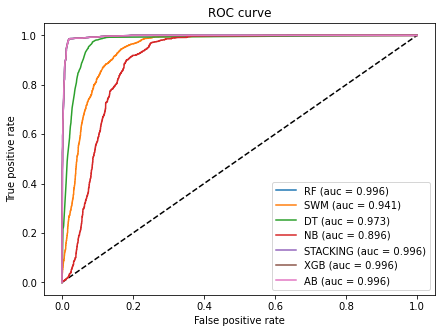

In [65]:
plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--') # dashed line with black(k) color
plt.plot(fpr_rf, tpr_rf, label='RF (auc = %0.3f)' % auc_rf)
plt.plot(fpr_swm, tpr_swm, label='SWM (auc = %0.3f)' % auc_svm)
plt.plot(fpr_dt, tpr_dt, label='DT (auc = %0.3f)' % auc_dt)
plt.plot(fpr_nb, tpr_nb, label='NB (auc = %0.3f)' % auc_nb)

plt.plot(fpr_stacking, tpr_stacking, label='STACKING (auc = %0.3f)' % auc_stacking)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_ab, tpr_ab, label='AB (auc = %0.3f)' % auc_ab)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Table overview: Different segments

### Segment amount 10

| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SWM | [0.90901609 0.82913128 0.83751363 0.79804735 0.79050442] | 0.8328425557402422 |
| Decision tree | [0.9091379  0.883873   0.85304185 0.8529422  0.78019421] | 0.8558378305694516 |
| Naive bayes | [0.79211907 0.80590641 0.75473713 0.73485348 0.62214168] | 0.7419515565474593 |
| Random forest | [0.91035706 0.88853696 0.85955471 0.85584218 0.78217434] | 0.859293050533927 |
| Stacking classifier | [0.91633424 0.88794029 0.85991648 0.86799686 0.77727863] | 0.8618933018364766 |
|<b> <font color='blue'>xgboost</font> </b> | [0.91781089 0.89484278 0.86629533 0.86209761 0.78692103] | <b>0.8655935272677568</b> |  
| adaBoost | [0.92504207 0.90307636 0.85256869 0.86064788 0.77918339] | 0.8641036786319866 |

### Segment amount 20
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SWM | [0.92118499 0.86178046 0.84719857 0.85588685 0.77298434] | 0.8518070430052868 |
| Decision tree | [0.90463721 0.89701568 0.87030209 0.88093824 0.78244283] | 0.8670672086146567 |
| Naive bayes | [0.51917108 0.55599557 0.40606327 0.50279532 0.57143782] | 0.5110926102570704 |
| Random forest | [0.90885777 0.89006886 0.88653765 0.90861018 0.80115661] | 0.8790462133976753 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.91872233 0.89636211 0.88322156 0.91809779 0.78941333] | <b>0.8811634252907714</b>|
| xgboost | [0.91116523 0.89531492 0.89047711 0.90500501 0.80120198] | 0.8806328505197618 |
| adaBoost | [0.92199619 0.89281512 0.87258715 0.88516904 0.77376375] | 0.8806328505197618 |

### Segment amount 60
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SWM | [0.92501342 0.88580256 0.86103527 0.89190853 0.80146878]| 0.8730457106959557 |
| Decision tree | [0.91315572 0.91338482 0.89238663 0.91800241 0.80481384] | 0.8883486859473735 |
| Naive bayes | [0.52095885 0.75022748 0.7663739  0.57082273 0.59400387] | 0.6404773642651375 |
| Random forest | [0.91854214 0.92321429 0.90506758 0.93944582 0.83117845] |  0.9034896542288781 |
| <b> <font color='blue'>Stacking classifier</font> </b> | [0.93226222 0.92338524 0.90520768 0.95202 0.82510008] | <b>0.9075950454507294</b> |
| xgboost | [0.91850551 0.91925385 0.90759045 0.94505354 0.83007033] | 0.9040947345160714 |
| adaBoost | [0.92001345 0.91576532 0.88294673 0.92885481 0.80175305] | 0.8898666720527755 |

### Segment amount 120
| Classifier | Scores | Mean Score |
| :- | :- | :- |
| SWM | [0.92325695 0.90212192 0.85257555 0.93080192 0.7934675]| 0.880444768805296 |
| Decision tree | [0.89160153 0.91648605 0.872511   0.94446946 0.81329853] | 0.8876733146580251 |
| Naive bayes | [0.31960951 0.32006774 0.7210034  0.32006774 0.45711168] | 0.4275720135667657 |
| <b> <font color='blue'>Random forest</font> </b> | [0.91749582 0.93126885 0.89715865 0.96097628 0.8130069] |  <b>0.9039812993810619</b> |
| Stacking classifier | [0.9283578  0.93419934 0.88484117 0.96806379 0.80084259] | 0.903260937296853 |
| xgboost | [0.89934208 0.92393306 0.89098086 0.95323892 0.81823833] | 0.8971466500331117 |
| adaBoost | [0.92644658 0.92807614 0.87398324 0.943755 0.80205616] | 0.894863424594331 |

# GridsearchCV

In [ ]:
# from sklearn.model_selection import GridSearchCV
# pipeline_nb.get_params().keys()

In [ ]:
# from time import time
# t0 = time()
# parameters = {'svm_classifier__C':[1, 10, 20], 'svm_classifier__kernel':['linear', 'rbf']}
# #parameters = {'rf_classifier__n_estimators': [200, 700], 'rf_classifier__max_features': ['auto', 'sqrt', 'log2'], 'rf_classifier__criterion':['gini','entropy']}
# clf = GridSearchCV(pipeline_swm, parameters, cv=5)
# clf.fit(X_train, y_train)
# print("done in %0.3fs" % (time() - t0))

In [ ]:
#df_search_results = pd.DataFrame(clf.cv_results_)
#df_search_results

In [ ]:
#df_search_results[['param_rf_classifier__criterion', 'param_rf_classifier__max_depth', 'mean_test_score']]
#clf.best_params_